# Optimization of the spatial profile

Idea:
 - The goal is to extract a flux, reproject it on the detector and determine a correction on the spatial profile using this projection
 - For a given pixel, we don't know to which order the correction corresponds, so we assume that the correction is proportional to the previous estimate of the spatial profile of each order.
 - We also assume that the correction we want to bring is a fraction of the estimate of the error. This is know as a fixed point iteration method

Definitions:
 - $P_i$: Real spatial profile at order $i$
 - $P^{(j)}_i$: $j$ th estimate of the spatial profile at order $i$
 - $\epsilon^{(j)}_i$ estimate of the error of $P^{(j)}_i$ compared to $P_i$, so that $\epsilon^{(j)}_i = P_i - P^{(j)}_i$
 - $E^{(n)}$: Relative error of the rebuilt detector (compared to the data). Given by the equation: (detector - rebuilt) / rebuilt
 - $\alpha$: scale factor

Description: <br>
If we assume that the error $\epsilon^{(j)}_i$ at a given pixel is proportional to the spatial profile estimate of each order ($P^{(j)}_i$), we can demonstrate that
\begin{equation}
\epsilon^{(j)}_1 = \frac{P^{(j)}_1}{P^{(j)}_2} \epsilon^{(j)}_2 ,
\end{equation}
assuming we have 2 orders.

Then, if we assume that a pixel (or the detector) can be modeled as

\begin{equation}
M^{(j)} = (P^{(j)}_1 + \epsilon^{(j)}_1) \int_1 (...) d\lambda \, + \,\, (P^{(j)}_2 + \epsilon^{(j)}_2) \int_2 (...) d\lambda  ,
\end{equation}
we can conclude that
\begin{equation}
\epsilon^{(j)}_i = P^{(j)}_i E^{(j)}
\end{equation}

Finally, the next estimate of $P_i$ will be given by $P^{(j+1)}_i = P^{(j)}_i + \alpha \epsilon^{(j)}_i = P^{(j)}_i + \alpha P^{(j)}_i E^{(j)}$.

Convergence:
- This has the form $g(P_i) = P_i + \alpha f(P_i)$ and we are looking to find $P_i^*$ such that $g(P_i^*) = P_i^*$. That is the definition of a **fixed point**.
- A typical stopping criterion is to require that
\begin{equation}
    \frac{|P_i^{(j+1)} - P_i^{(j)}|}{max(P_i^{(j)}, \xi)} < tol_i
\end{equation}
where $\xi$ ensures that the criterion does not diverge if $P_i$ is close to zero. $tol_i$ is the relative tolerance of a given pixel. The relative error map could be used.



## Imports

In [1]:
# Import standard packages.
import numpy as np
from astropy.io import fits

# Imports from the extraction.
from extract.overlap import TrpzOverlap
from extract.throughput import ThroughputSOSS
from extract.convolution import WebbKer

# Imports for plots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # For displaying of FITS images.
# TODO astropy has some nice functions for colorbars scaling of astronomical data, might be worth looking into.

### Matplotlib defaults

In [2]:
%matplotlib inline

In [34]:
plt.rc('figure', figsize=(13,8)) 
plt.rc('font', size=16)
plt.rc('image', cmap='inferno')
plt.rc('lines', lw=2)

## Load simulation

In [4]:
# Import custom function to read toy simulation
from sys import path  # TODO all import should be at the top. 
# Answer: this is temporary since we should have better simulations eventually
#         and my format was very custom. That's why I let this whole section
#         in a separate bloc.
path.append("Fake_data")
from simu_utils import load_simu  # TODO can this function be moved to utils?
# Answer: same as previous comment: very custom format. Should be changed.
# Load a simulation
simu = load_simu("../../Simulations/phoenix_teff_09000_scale_1.0e+02_vsini_5_gaussker_notilt.fits")
data = simu["data"]

## Read some ref files

In [5]:
from extract.convolution import fwhm2sigma, gaussians
from scipy.interpolate import interp1d

class GaussKer:

    def __init__(self, grid, res, bounds_error=False,
                 fill_value="extrapolate", **kwargs):
        """
        Parameters
        ----------
        grid : 1d array
            Grid used to define the kernels
        fwhm: ...
            ...
        bounds_error, fill_value and kwargs:
            `interp1d` kwargs used to get FWHM as a function of the grid.
        """
        fwhm = grid / res
        
        # What we really want is sigma, not FWHM
        sig = fwhm2sigma(fwhm)

        # Now put sigma as a function of the grid
        sig = interp1d(grid, sig, bounds_error=bounds_error,
                       fill_value=fill_value, **kwargs)

        self.fct_sig = sig

    def __call__(self, x, x0):
        """
        Parameters
        ----------
        x: 1d array
            position where the kernel is evaluated
        x0: 1d array (same shape as x)
            position of the kernel center for each x.

        Returns
        -------
        Value of the gaussian kernel for each sets of (x, x0)
        """

        # Get the sigma of each gaussians
        sig = self.fct_sig(x0)

        return gaussians(x, x0, sig)

In [6]:
path = "extract/Ref_files/"

# List of orders to consider in the extraction
order_list = [1, 2]

#### Wavelength solution ####
wave_maps = []
wave_maps.append(fits.getdata(path + "wavelengths_m1.fits"))
wave_maps.append(fits.getdata(path + "wavelengths_m2.fits"))

# Remove the tilt from wv maps
wave_maps[0] = np.tile(wave_maps[0][50,:], (256, 1))
wave_maps[1] = np.tile(wave_maps[1][50,:], (256, 1))

#### Spatial profiles ####
spat_pros = []
spat_pros.append(fits.getdata(path + "spat_profile_m1.fits").squeeze())
spat_pros.append(fits.getdata(path + "spat_profile_m2.fits").squeeze())

# Convert data from fits files to float (fits precision is 1e-8)
wave_maps = [wv.astype('float64') for wv in wave_maps]
spat_pros = [p_ord.astype('float64') for p_ord in spat_pros]

#### Throughputs ####
thrpt_list = [ThroughputSOSS(order) for order in order_list]

#### Convolution kernels ####
# ker_list = [WebbKer(wv_map) for wv_map in wave_maps]
ker_list = [GaussKer(simu["grid"], res) for res in [2000, 900]]

# Put all inputs from reference files in a list
ref_files_args = [spat_pros, wave_maps, thrpt_list, ker_list]

## Extraction

### Extraction Parameters
(Example usage with few inputs parameters.)

In [7]:
params = {}

# Map of expected noise (standard deviation).
bkgd_noise = 20.  # In counts?

# Wavelength extraction grid oversampling.
params["n_os"] = 3  # TODO explain a bit more how the grid is determined?
# Answer: I was thinking of explaining all inputs in another notebook or text?
#         Since this parameter is needed for every extraction, I didn't want
#         to re-explain it in all examples. What do you think?

# Threshold on the spatial profile. 
# Only pixels above this threshold will be used for extraction.
# (for at least one order)
params["thresh"] = 1e-4  # Same units as the spatial profiles

### Initiate extraction object
(This needs to be done only once unless the oversampling (`n_os`) changes.)

In [8]:
extract = TrpzOverlap(*ref_files_args, c_kwargs={'thresh':1e-6}, **params)

### Find the best tikhonov factor
This takes some time, so it's better to do it once if the exposures are part of a time series observation, i.e. observations of the same object at similar SNR.

Testing factors...
14/14


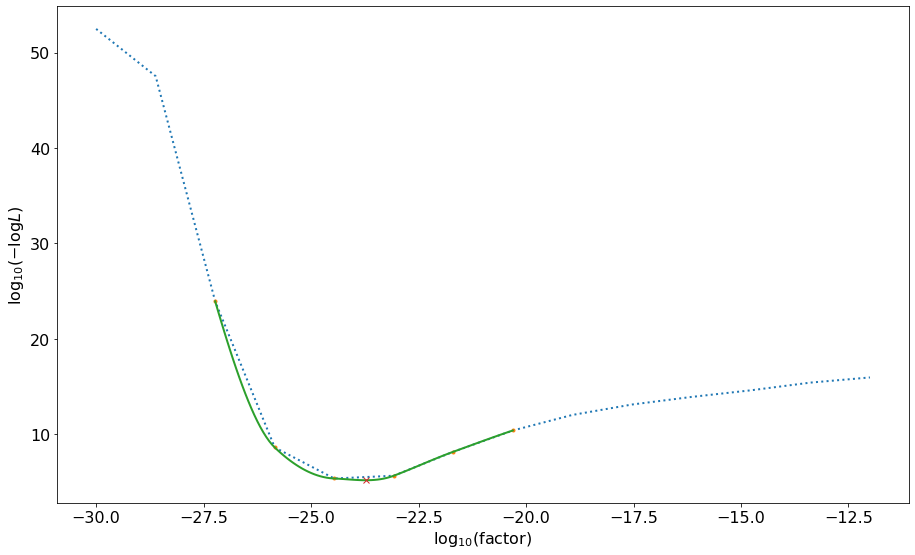

In [9]:
# Determine which factors to tests.
factors = np.logspace(-30, -12, 14)

# Noise estimate to weigh the pixels.
# Poisson noise + background noise.
sig = np.sqrt(data + bkgd_noise**2)

# Tests all these factors.
tests = extract.get_tikho_tests(factors, data=data, sig=sig)  # TODO sig is the uncertainty on the date here so it might be good to call it that?

# Find the best factor.
best_fac = extract.best_tikho_factor(tests=tests, i_plot=True)

Testing factors...
20/20


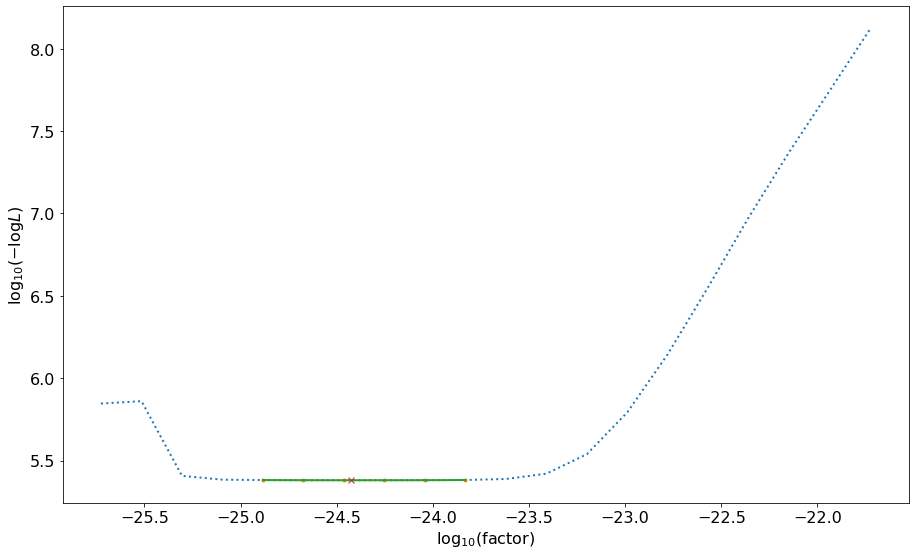

In [10]:
# Refine the grid (span 4 orders of magnitude).
best_fac = np.log10(best_fac)
factors = np.logspace(best_fac-2, best_fac+2, 20)

# No need to specify `data` and `sig` again. 
# TODO: why not? Wouldn't it be better to require that to avoid confusion?
# Answer: When a reference file or science file is specified, the class keeps it
#         as an attribute. When an extraction is called, it is updated if specified.
#         It is done to save some text when iterating on the spatial profile, for
#         example, and to save time (some matrix multiplications don't need to be 
#         re-computed). But I'm open to discuss it!
tests = extract.get_tikho_tests(factors, data=data, sig=sig)
best_fac = extract.best_tikho_factor(tests=tests, i_plot=True)

### Compare result to injected spectrum

In [11]:
simu

{'grid': array([0.55023961, 0.55028641, 0.55033321, ..., 2.9994292 , 2.99953116,
        2.99963313]),
 'f_k': array([0.00000000e+00, 0.00000000e+00, 4.71662185e+17, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'grid_c1': array([0.83836296, 0.83840966, 0.83845637, ..., 2.83565548, 2.83575684,
        2.83585819]),
 'f_c1': array([1.26299948e+17, 1.26259358e+17, 1.26218258e+17, ...,
        2.25147203e+15, 2.25114710e+15, 2.25082181e+15]),
 'grid_c2': array([0.55403148, 0.55407838, 0.55412527, ..., 1.41141275, 1.41145937,
        1.41150598]),
 'f_c2': array([4.64483527e+17, 4.64532134e+17, 4.64546420e+17, ...,
        2.78077120e+16, 2.78041710e+16, 2.78006384e+16]),
 'data': array([[-3.94470707e+01, -1.16371635e+01,  1.85875482e+01, ...,
          1.63622373e+01,  1.06282090e+01,  1.08002126e+01],
        [-2.72396518e+01,  2.75713459e+01,  4.40761418e+00, ...,
          2.94759347e+00, -5.29149824e+00,  1.89465258e+01],
        [ 1.07829740e+00,  2.56334994e+01, -1

In [12]:
f_k = extract(data=data, sig=sig, p_list=spat_pros, tikhonov=True, factor=best_fac)
# f_k = extract(data=data, sig=sig, p_list=spat_pros)

In [13]:
rebuilt = extract.rebuild(f_k)

In [36]:
%matplotlib notebook

In [15]:
plt.plot?

<IPython.core.display.Javascript object>


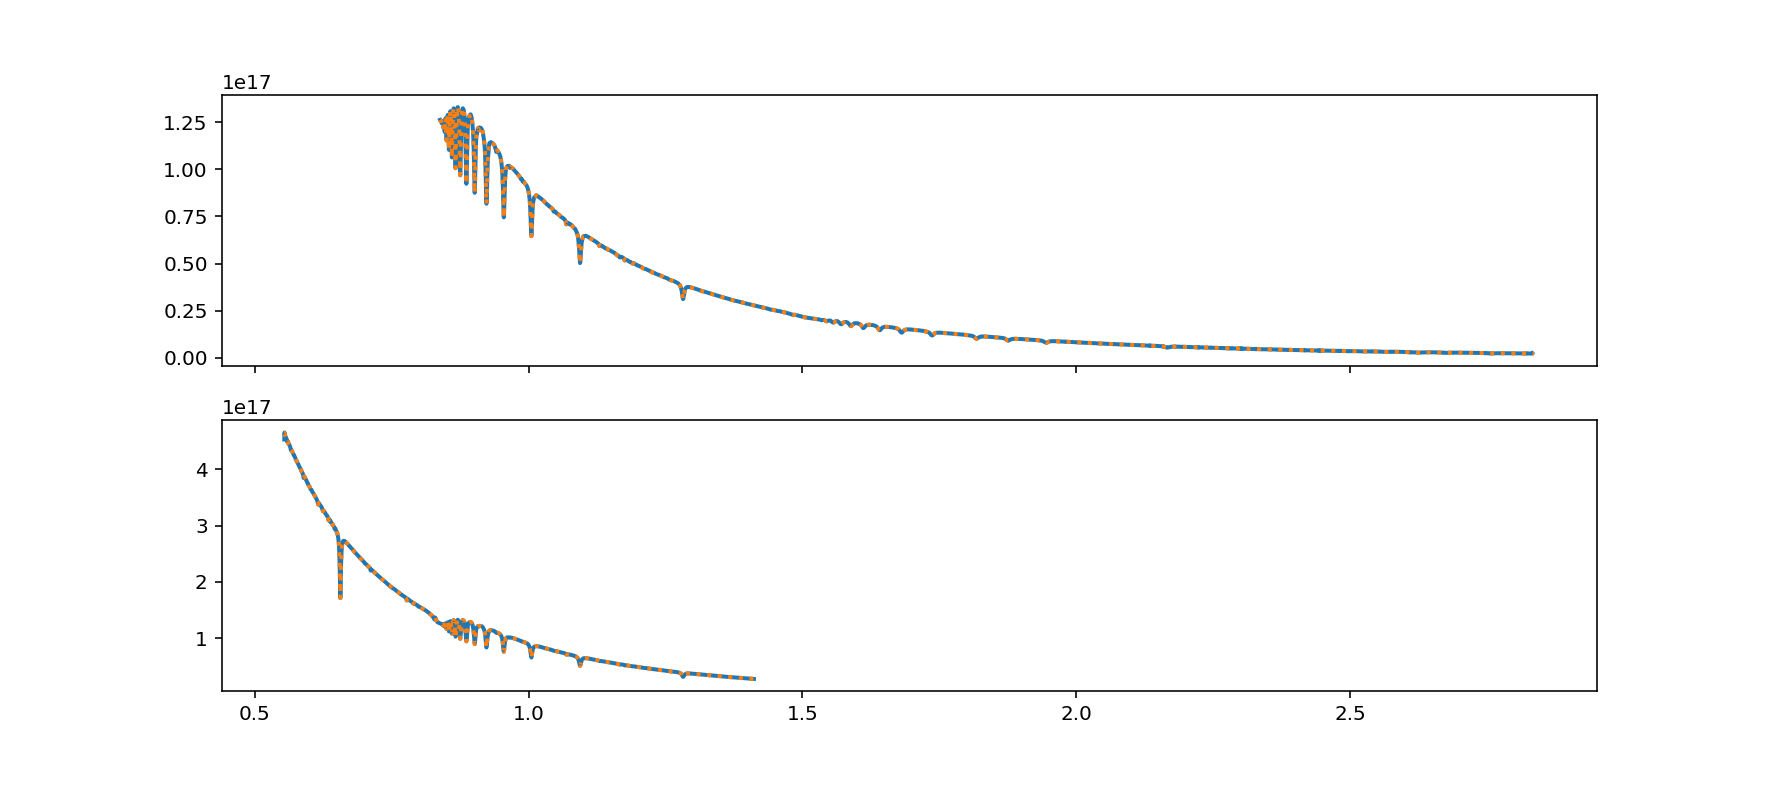

In [19]:
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(extract.lam_grid_c(0), extract.c_list[0].dot(f_k))
ax[0].plot('grid_c1', 'f_c1', ":", data=simu)

ax[1].plot(extract.lam_grid_c(1), extract.c_list[1].dot(f_k))
ax[1].plot('grid_c2', 'f_c2', ":", data=simu)

In [45]:
plt.pcolormesh?

In [20]:
from scipy.interpolate import interp1d

In [21]:
extract.bin_to_pixel?

<IPython.core.display.Javascript object>


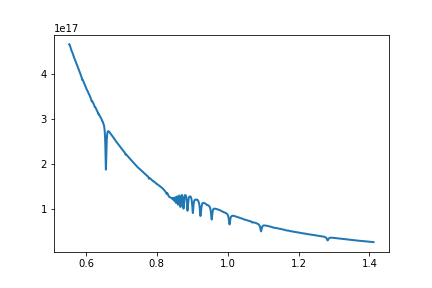

In [17]:
# plt.plot(extract.lam_grid_c(1), extract.c_list[1].dot(f_k))
plt.plot(simu['grid_c2'], simu['f_c2'])

<IPython.core.display.Javascript object>


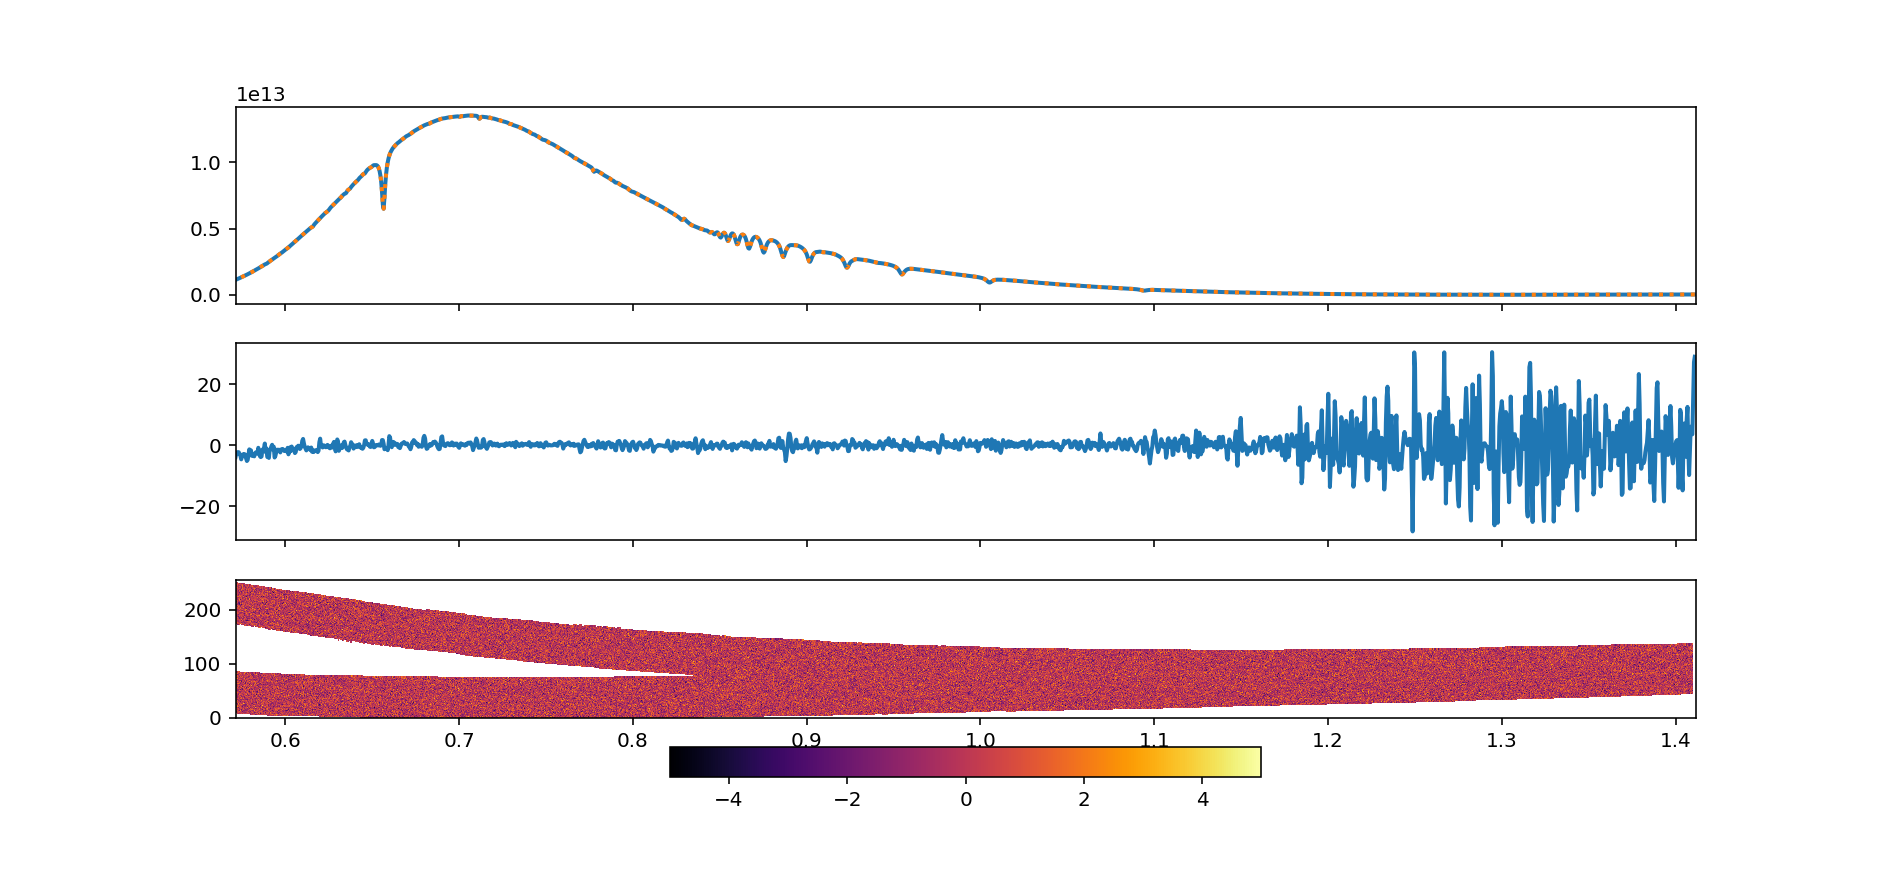

In [22]:
fig, ax = plt.subplots(3, 1, sharex=True)

grid_bin, f_bin = extract.bin_to_pixel(f_k_c=extract.c_list[1].dot(f_k),
                                       grid_pix=wave_maps[1][100,:1800],
                                       grid_f_k=extract.lam_grid_c(1), i_ord=1)
_, f_bin_th = extract.bin_to_pixel(f_k_c=simu['f_c2'], grid_pix=grid_bin, grid_f_k=simu['grid_c2'], i_ord=1)

ax[0].plot(grid_bin, f_bin)
ax[0].plot(grid_bin, f_bin_th, ":")

# f_th_interp = interp1d(simu['grid_c2'], simu['f_c2'], kind='cubic', bounds_error=False, fill_value=np.nan)
ax[1].plot(grid_bin, (f_bin-f_bin_th)/f_bin_th*1e6)

im = ax[-1].pcolormesh(wave_maps[1][100,:1800], np.arange(256), ((rebuilt-data)/sig)[:, :1800], vmin=-5, vmax=5)
# plt.imshow((rebuilt-data)/sig, vmin=-5, vmax=5., interpolation=None)
plt.colorbar(im, ax=ax[-1], orientation="horizontal")

<IPython.core.display.Javascript object>


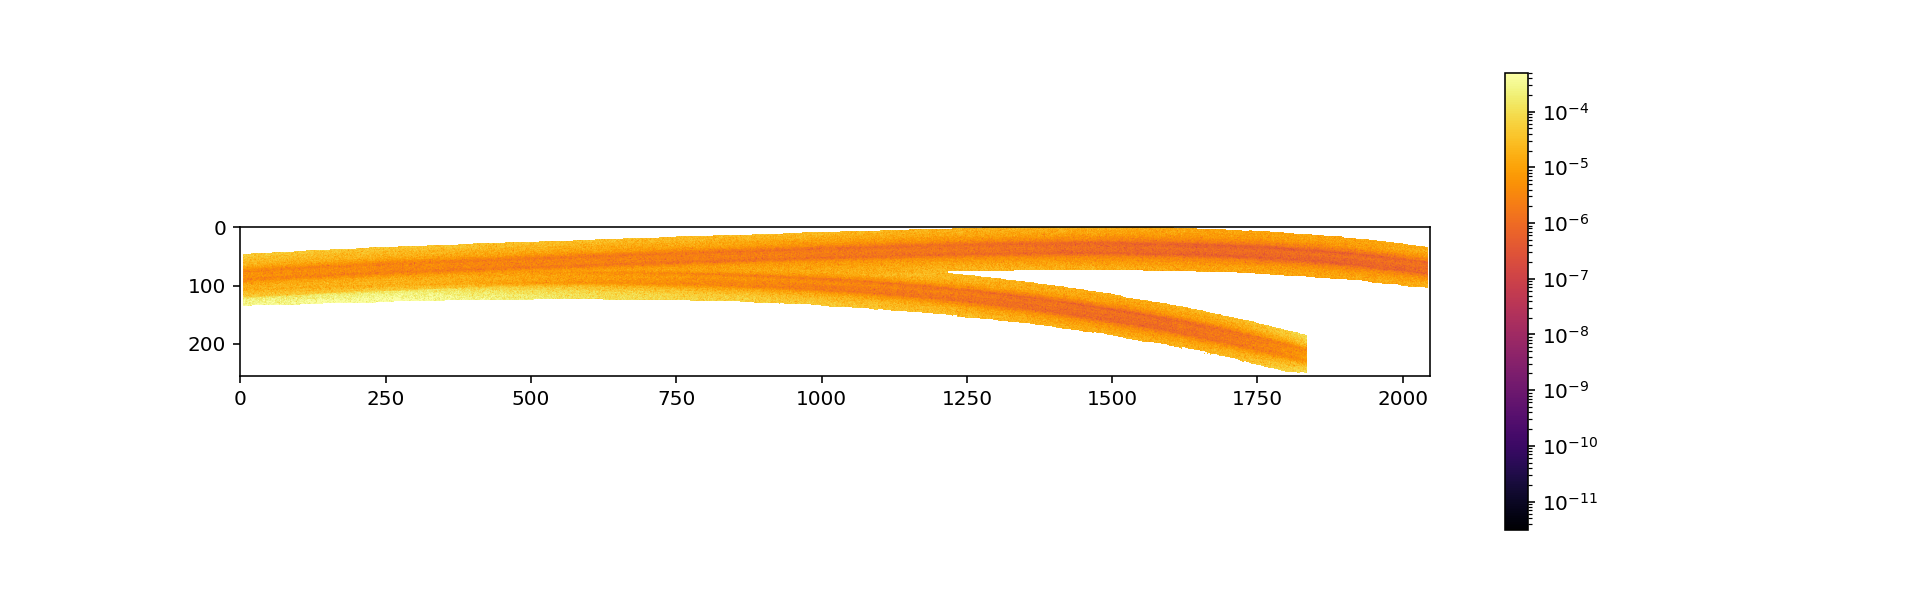

In [23]:
plt.figure()
plt.imshow(np.abs(rebuilt-data)/data, vmax=0.5e-3, norm=LogNorm(), interpolation=None)
plt.colorbar()

### Optimize the spatial profiles

In [26]:
import time

In [27]:
def optimize_profile(self, f_k=None, min_val=1e-3, rtol_map=None,
                     scale_factor=0.1, max_iter=50, n_sample=10, max_sample=20, **kwargs):
    
    # Use object error map to generate a relative
    # error map if `rtol_map` not given
    if rtol_map is None:
        rtol_map = 3 * self.sig / self.data
        
    # extract f_k if not given
    if f_k is None:
        f_k = self(**kwargs)
    
    # Get spatial profiles from object
    p_list = np.array(self.p_list)
    # Save total spatial profile for each column.
    # It should be ~equal to 1, unless the trace goes
    # out of the detector.
    p_tot = np.nansum(p_list, axis=1)
    
    # Iterate
    p_save = []
    # Masked pixels are considered converged
    # TODO: use real mask, deal with normalisation and masks.
    mask = np.array(self.mask_ord)
    pix_converged = np.isnan(p_list)
    p_sum = np.zeros(p_list.shape, dtype=float)
    n_p_sum = np.zeros(p_list.shape, dtype=int)
    converged = False
    i_sample = 0
    
    fig = plt.figure(figsize=(12,12))
    N = 6
    cycler = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))
    colors = cycler.by_key()['color']
    
    i_col_plot = 800
    plt.plot((rtol_map*p_list[0])[50:130, i_col_plot], "k--", alpha=0.4)
    plt.plot((rtol_map*p_list[1])[50:130, i_col_plot], "k", alpha=0.4)
    
    for i in range(max_iter):
        # Get relative error
        rel_err = get_rel_err(self, f_k)

        # Weigh the error depending on the order contribution at each pixel
        # The result is the absolute (not relative) error for each orders
        p_error = rel_err * p_list
        
        # Test convergence
        # Define criterion
        denominator = np.clip(np.abs(p_list), min_val, None)
        criterion = (np.abs(p_error) / denominator)
        # Convert to masked array
        criterion = np.ma.masked_invalid(criterion)
        # Update map of converged pixels
        pix_converged[criterion < rtol_map] = True
        # Check global convergence
        if converged or pix_converged.all():
            # State convergence
            converged = True
            # Make `n_sample` iteration after convergence
            i_sample += 1
            print("Converged.", i_sample, "/", n_sample)
        else:
            print(i, ", mean rel errors: ", criterion[0].mean(), criterion[1].mean(),
                  ", not converged: ", (~pix_converged)[0].sum(), (~pix_converged)[1].sum())        
        
        # Correct p_list with scaled correction
        p_list = p_list + p_error * scale_factor
        
        # Enforce normalization
        norm = np.divide(np.nansum(p_list, axis=1), p_tot,
                         out=np.zeros_like(p_tot), where=p_tot!=0)[:, None, :]
        p_list = np.divide(p_list, norm, out=np.zeros_like(p_list), where=norm!=0)
        
        # Save value of converged pixels to make stats
        if pix_converged.any():
            p_to_save = np.ones_like(p_list) * np.nan
#             p_to_save[pix_converged] = p_list[pix_converged]
            p_to_save[~mask] = p_list.copy()[~mask]
            # Make sure p_save does not exceed `max_sample`
            p_save = p_save[-(max_sample - 1):]
            # Append
            p_save.append(p_to_save)
            
            
#             # Take mean for converged pixels
#             p_sum[pix_converged] += p_list[pix_converged]
#             n_p_sum[pix_converged] += 1
#             p_list[pix_converged] = p_sum[pix_converged]
#             p_list[pix_converged] /= n_p_sum[pix_converged]
#             if (n_p_sum[pix_converged] <= 0).any():
#                 print('weird')
            
            
        # Plot a slice of the spatial profile
        plt.plot(p_error[0, 50:130, i_col_plot], color=colors[i%N], linestyle="--")
        plt.plot(p_error[1, 50:130, i_col_plot], color=colors[i%N])
        fig.canvas.draw()
        time.sleep(1)

        # Stop when `n_sample` iteration after convergence
        if i_sample == n_sample:
            break
            
        # Re-extract
        f_k = self(p_list=p_list, **kwargs)

    else:
        print("*** Not converged: Reached max iteration ***")
        
    plt.show()
    return np.array(p_save)
    
def get_rel_err(self, f_k):
    """
    Return the relative error of the rebuilt detector image.
    """
    # Define an error map
    rebuilt = self.rebuild(f_k)
    rel_err = (self.data - rebuilt) / rebuilt

    return rel_err


<IPython.core.display.Javascript object>


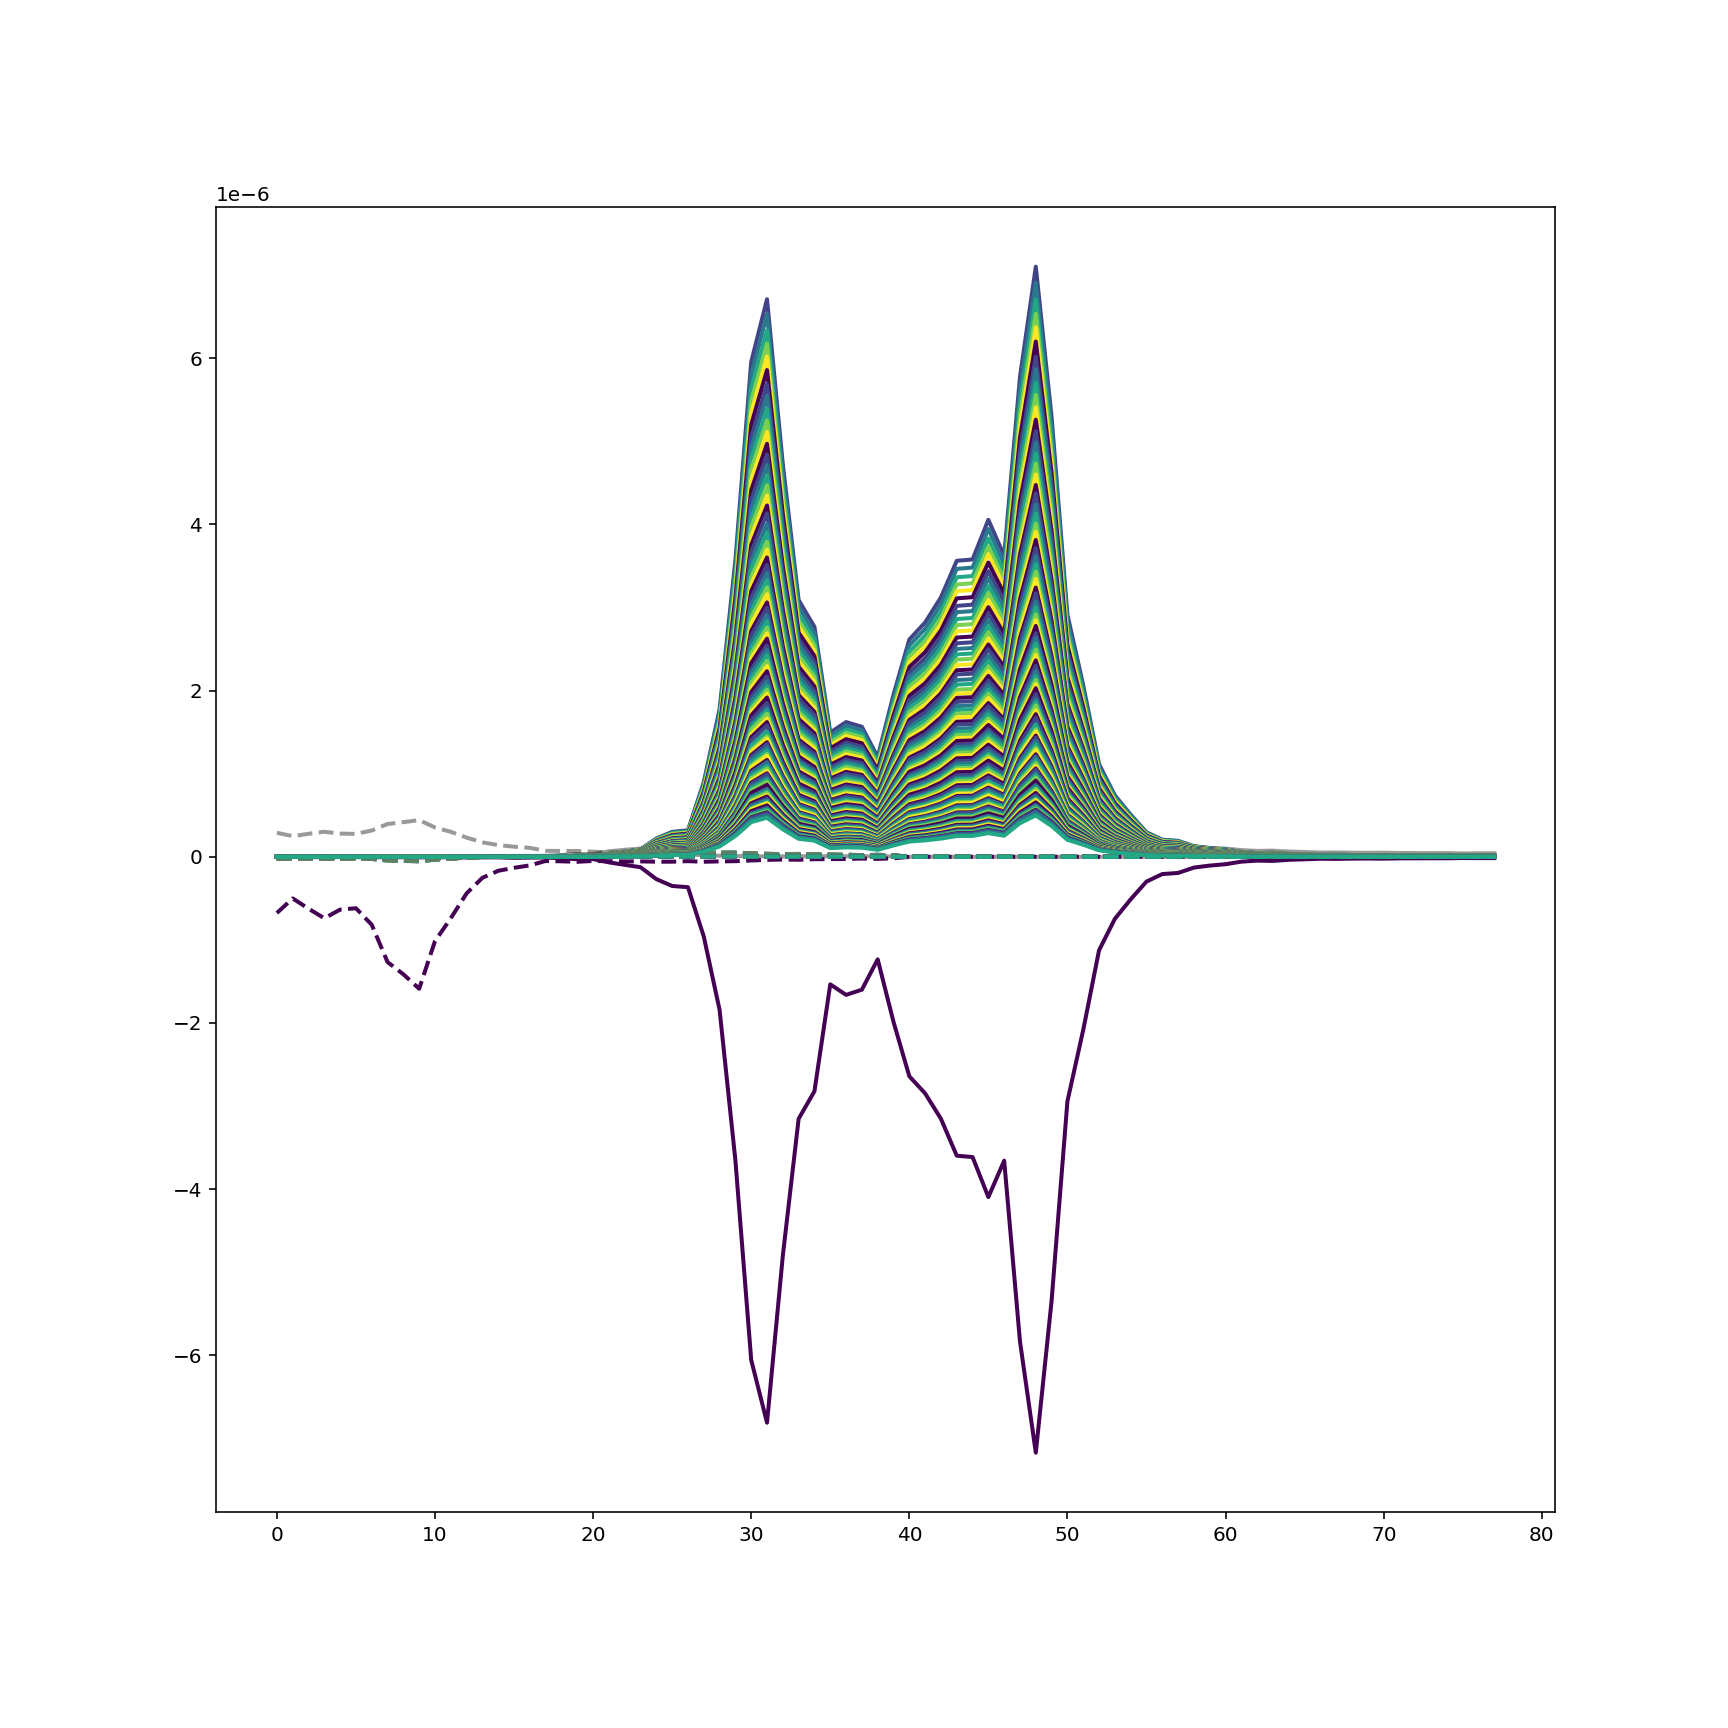

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


0 , mean rel errors:  3.612466996405329e-05 9.102192192136563e-05 , not converged:  82503 126230


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


1 , mean rel errors:  3.930006871062844e-06 1.5128644803019667e-05 , not converged:  15174 63515


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


2 , mean rel errors:  3.53182103789255e-06 1.4118978208746956e-05 , not converged:  14721 62704


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


3 , mean rel errors:  3.2948900084587308e-06 1.3481958988461789e-05 , not converged:  14269 61895


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


4 , mean rel errors:  3.137288279749192e-06 1.3038713895648974e-05 , not converged:  13896 61343


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


5 , mean rel errors:  3.0339464607478334e-06 1.2728446945360578e-05 , not converged:  13634 60969


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


6 , mean rel errors:  2.9537655634846952e-06 1.2473415723714121e-05 , not converged:  13484 60788


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


7 , mean rel errors:  2.8847718341528543e-06 1.2250490105217108e-05 , not converged:  13368 60665


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


8 , mean rel errors:  2.835352330278578e-06 1.2077726701198198e-05 , not converged:  13248 60525


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


9 , mean rel errors:  2.781061869560073e-06 1.1894314265585961e-05 , not converged:  13134 60412


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


10 , mean rel errors:  2.7353190269114135e-06 1.1734250457350724e-05 , not converged:  13035 60270


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


11 , mean rel errors:  2.690048650424836e-06 1.15746018067926e-05 , not converged:  12893 60110


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


12 , mean rel errors:  2.6540048346528107e-06 1.1440529694552098e-05 , not converged:  12791 59935


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


13 , mean rel errors:  2.619001113761944e-06 1.1312466344662904e-05 , not converged:  12671 59743


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


14 , mean rel errors:  2.5916904555802217e-06 1.1205060099346434e-05 , not converged:  12526 59557


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


15 , mean rel errors:  2.5610892751064565e-06 1.1088393391953945e-05 , not converged:  12418 59372


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


16 , mean rel errors:  2.534313473716137e-06 1.0983997965503375e-05 , not converged:  12306 59222


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


17 , mean rel errors:  2.508248579485815e-06 1.0883566331784858e-05 , not converged:  12207 59077


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


18 , mean rel errors:  2.48451193188103e-06 1.07852977475168e-05 , not converged:  12103 58911


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


19 , mean rel errors:  2.457617648552584e-06 1.0682245648007646e-05 , not converged:  12004 58752


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


20 , mean rel errors:  2.4387707398098475e-06 1.0602980074047351e-05 , not converged:  11909 58638


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


21 , mean rel errors:  2.419802990455128e-06 1.0520786062652963e-05 , not converged:  11812 58523


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


22 , mean rel errors:  2.4005335419924623e-06 1.0438632492388812e-05 , not converged:  11722 58416


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


23 , mean rel errors:  2.3797448480864362e-06 1.0355973362266996e-05 , not converged:  11651 58315


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


24 , mean rel errors:  2.3653648292243088e-06 1.0287468074303314e-05 , not converged:  11563 58220


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


25 , mean rel errors:  2.345307718945217e-06 1.0205553760240165e-05 , not converged:  11477 58132


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


26 , mean rel errors:  2.327298276892166e-06 1.0130927035473613e-05 , not converged:  11407 58045


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


27 , mean rel errors:  2.3156077097753297e-06 1.0072090763238589e-05 , not converged:  11329 57966


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


28 , mean rel errors:  2.292738930646386e-06 9.987001005557289e-06 , not converged:  11260 57878


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


29 , mean rel errors:  2.276014436190228e-06 9.916442587722739e-06 , not converged:  11191 57790


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


30 , mean rel errors:  2.2661456137410225e-06 9.861868215972038e-06 , not converged:  11129 57715


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


31 , mean rel errors:  2.2502272447396688e-06 9.795917047906046e-06 , not converged:  11058 57617


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


32 , mean rel errors:  2.2331381496572273e-06 9.727429546509122e-06 , not converged:  10988 57532


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


33 , mean rel errors:  2.2196588562377257e-06 9.668128123451301e-06 , not converged:  10924 57451


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


34 , mean rel errors:  2.2063600668355632e-06 9.607694592089789e-06 , not converged:  10866 57376


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


35 , mean rel errors:  2.1921425895528296e-06 9.545878933535886e-06 , not converged:  10812 57295


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


36 , mean rel errors:  2.185787672652622e-06 9.503329777429995e-06 , not converged:  10761 57209


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


37 , mean rel errors:  2.1696013887209143e-06 9.441099718714324e-06 , not converged:  10713 57128


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


38 , mean rel errors:  2.1544203714413338e-06 9.379539991653307e-06 , not converged:  10653 57051


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


39 , mean rel errors:  2.137295153008002e-06 9.311044443909739e-06 , not converged:  10601 56991


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


40 , mean rel errors:  2.1320216288311657e-06 9.273140257115678e-06 , not converged:  10538 56925


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


41 , mean rel errors:  2.120528880645884e-06 9.221858697035316e-06 , not converged:  10475 56840


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


42 , mean rel errors:  2.110563107284894e-06 9.175646063031105e-06 , not converged:  10438 56772


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


43 , mean rel errors:  2.0937246106884473e-06 9.111353403659497e-06 , not converged:  10402 56705


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


44 , mean rel errors:  2.0854594832960857e-06 9.071331279856027e-06 , not converged:  10359 56627


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


45 , mean rel errors:  2.076715164952235e-06 9.028245835767393e-06 , not converged:  10313 56568


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


46 , mean rel errors:  2.0673914570030766e-06 8.980913776725841e-06 , not converged:  10251 56493


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


47 , mean rel errors:  2.0575314954721533e-06 8.934467730044328e-06 , not converged:  10196 56424


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


48 , mean rel errors:  2.0467289689469382e-06 8.887899290813672e-06 , not converged:  10150 56353


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


49 , mean rel errors:  2.0373561000112856e-06 8.84386598235369e-06 , not converged:  10101 56283


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


50 , mean rel errors:  2.022509919834423e-06 8.78709313540581e-06 , not converged:  10064 56211


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


51 , mean rel errors:  2.0185394254428072e-06 8.758451321505662e-06 , not converged:  10028 56150


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


52 , mean rel errors:  2.0089222227042243e-06 8.709484197386486e-06 , not converged:  9993 56099


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


53 , mean rel errors:  1.9967508076937823e-06 8.663766453913019e-06 , not converged:  9948 56033


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


54 , mean rel errors:  1.990818690342215e-06 8.629901568634101e-06 , not converged:  9902 55974


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


55 , mean rel errors:  1.980662095855703e-06 8.585697982750856e-06 , not converged:  9869 55909


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


56 , mean rel errors:  1.975072295961217e-06 8.551301119804208e-06 , not converged:  9837 55842


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


57 , mean rel errors:  1.963192867712744e-06 8.504098197797646e-06 , not converged:  9812 55799


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


58 , mean rel errors:  1.957558134113124e-06 8.472342443962114e-06 , not converged:  9780 55753


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


59 , mean rel errors:  1.953957207837032e-06 8.448192384346915e-06 , not converged:  9744 55717


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


60 , mean rel errors:  1.9397111293997228e-06 8.393061799709309e-06 , not converged:  9719 55669


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


61 , mean rel errors:  1.9314465424130276e-06 8.354997722488766e-06 , not converged:  9691 55620


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


62 , mean rel errors:  1.9214039820952795e-06 8.313254292733782e-06 , not converged:  9662 55565


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


63 , mean rel errors:  1.918794365216188e-06 8.289623135605642e-06 , not converged:  9641 55516


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


64 , mean rel errors:  1.9121374500870928e-06 8.255279311247852e-06 , not converged:  9619 55465


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


65 , mean rel errors:  1.9085427003598017e-06 8.227826495719717e-06 , not converged:  9590 55410


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


66 , mean rel errors:  1.898724510286145e-06 8.189500305504935e-06 , not converged:  9560 55362


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


67 , mean rel errors:  1.8838073301102337e-06 8.13560872378205e-06 , not converged:  9536 55315


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


68 , mean rel errors:  1.8804274492535716e-06 8.10976449989317e-06 , not converged:  9509 55277


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


69 , mean rel errors:  1.8736535542541025e-06 8.080375965944724e-06 , not converged:  9479 55227


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


70 , mean rel errors:  1.8635932331132114e-06 8.039331565375958e-06 , not converged:  9466 55193


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


71 , mean rel errors:  1.861219270923836e-06 8.017795768861987e-06 , not converged:  9442 55158


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


72 , mean rel errors:  1.855089846972886e-06 7.985522556486837e-06 , not converged:  9416 55112


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


73 , mean rel errors:  1.8446581256468568e-06 7.944271902832683e-06 , not converged:  9389 55072


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


74 , mean rel errors:  1.8434512401946962e-06 7.923207867044991e-06 , not converged:  9366 55035


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


75 , mean rel errors:  1.8405994400815389e-06 7.903480527590994e-06 , not converged:  9334 54989


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


76 , mean rel errors:  1.82580045488386e-06 7.854474772935738e-06 , not converged:  9312 54950


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


77 , mean rel errors:  1.8189827248076318e-06 7.823455453618636e-06 , not converged:  9289 54918


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


78 , mean rel errors:  1.8253683217457652e-06 7.819372249486873e-06 , not converged:  9269 54885


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


79 , mean rel errors:  1.8101824978653301e-06 7.772265808412659e-06 , not converged:  9237 54834


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


80 , mean rel errors:  1.8067160303539032e-06 7.747423048730947e-06 , not converged:  9217 54791


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


81 , mean rel errors:  1.7998015289743807e-06 7.719003073840494e-06 , not converged:  9199 54753


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


82 , mean rel errors:  1.7933136856724667e-06 7.686489432795518e-06 , not converged:  9179 54719


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


83 , mean rel errors:  1.7897781121979279e-06 7.665366420370574e-06 , not converged:  9152 54687


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


84 , mean rel errors:  1.7785021733015526e-06 7.623970615806401e-06 , not converged:  9133 54646


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


85 , mean rel errors:  1.777308936214776e-06 7.606357361005902e-06 , not converged:  9109 54608


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


86 , mean rel errors:  1.7742436809943933e-06 7.586859897443223e-06 , not converged:  9087 54576


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


87 , mean rel errors:  1.7711572665506193e-06 7.565288511376594e-06 , not converged:  9064 54543


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


88 , mean rel errors:  1.7579555302723594e-06 7.521104145736252e-06 , not converged:  9044 54506


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


89 , mean rel errors:  1.7518398366868584e-06 7.493199648836012e-06 , not converged:  9026 54469


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


90 , mean rel errors:  1.7545110766059505e-06 7.48528332843289e-06 , not converged:  9005 54434


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


91 , mean rel errors:  1.7426022977072651e-06 7.444647835331156e-06 , not converged:  8980 54387


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


92 , mean rel errors:  1.7366220031393392e-06 7.4170621897136435e-06 , not converged:  8959 54353


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


93 , mean rel errors:  1.736206948048498e-06 7.400716000694304e-06 , not converged:  8942 54318


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


94 , mean rel errors:  1.722068630919237e-06 7.355473919449203e-06 , not converged:  8929 54289


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


95 , mean rel errors:  1.7250764482300045e-06 7.350236132120698e-06 , not converged:  8910 54262


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


96 , mean rel errors:  1.7232716911600437e-06 7.333086099142997e-06 , not converged:  8891 54235


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


97 , mean rel errors:  1.7111441770627201e-06 7.2930061316240056e-06 , not converged:  8874 54198


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


98 , mean rel errors:  1.7084636911385574e-06 7.274589452421498e-06 , not converged:  8859 54169


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


99 , mean rel errors:  1.7025528360506179e-06 7.2479266091758575e-06 , not converged:  8842 54145
*** Not converged: Reached max iteration ***


In [37]:
spat_pros_estimates = optimize_profile(extract, f_k=f_k, tikhonov=True,
                                       factor=best_fac, scale_factor=0.8, max_iter=100)

In [38]:
plt.close()

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


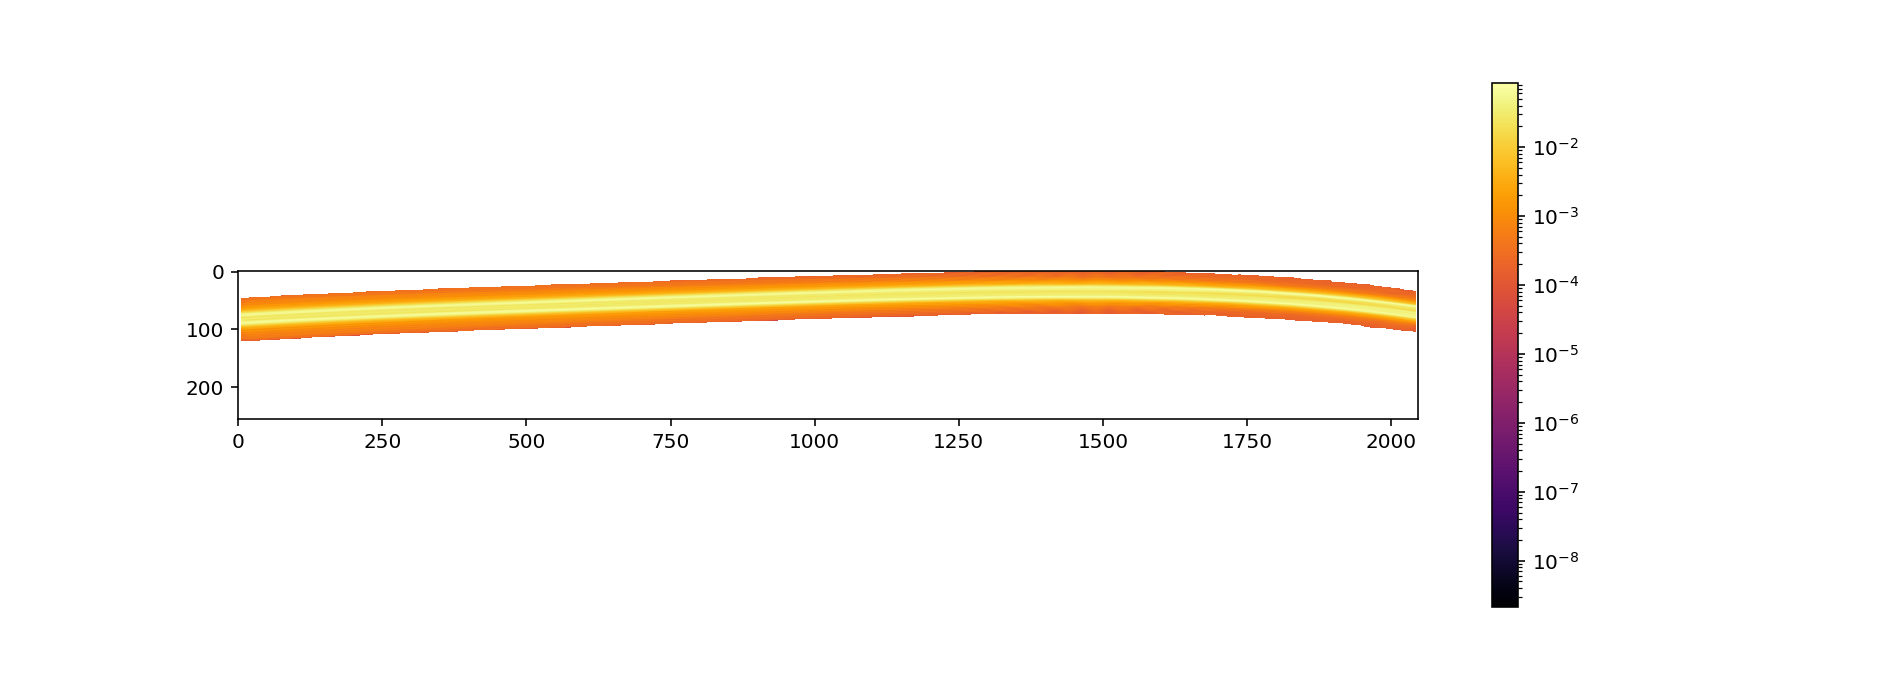

In [39]:
plt.imshow(np.nanmean(spat_pros_estimates, axis=0)[0], norm=LogNorm())
plt.colorbar()

<IPython.core.display.Javascript object>


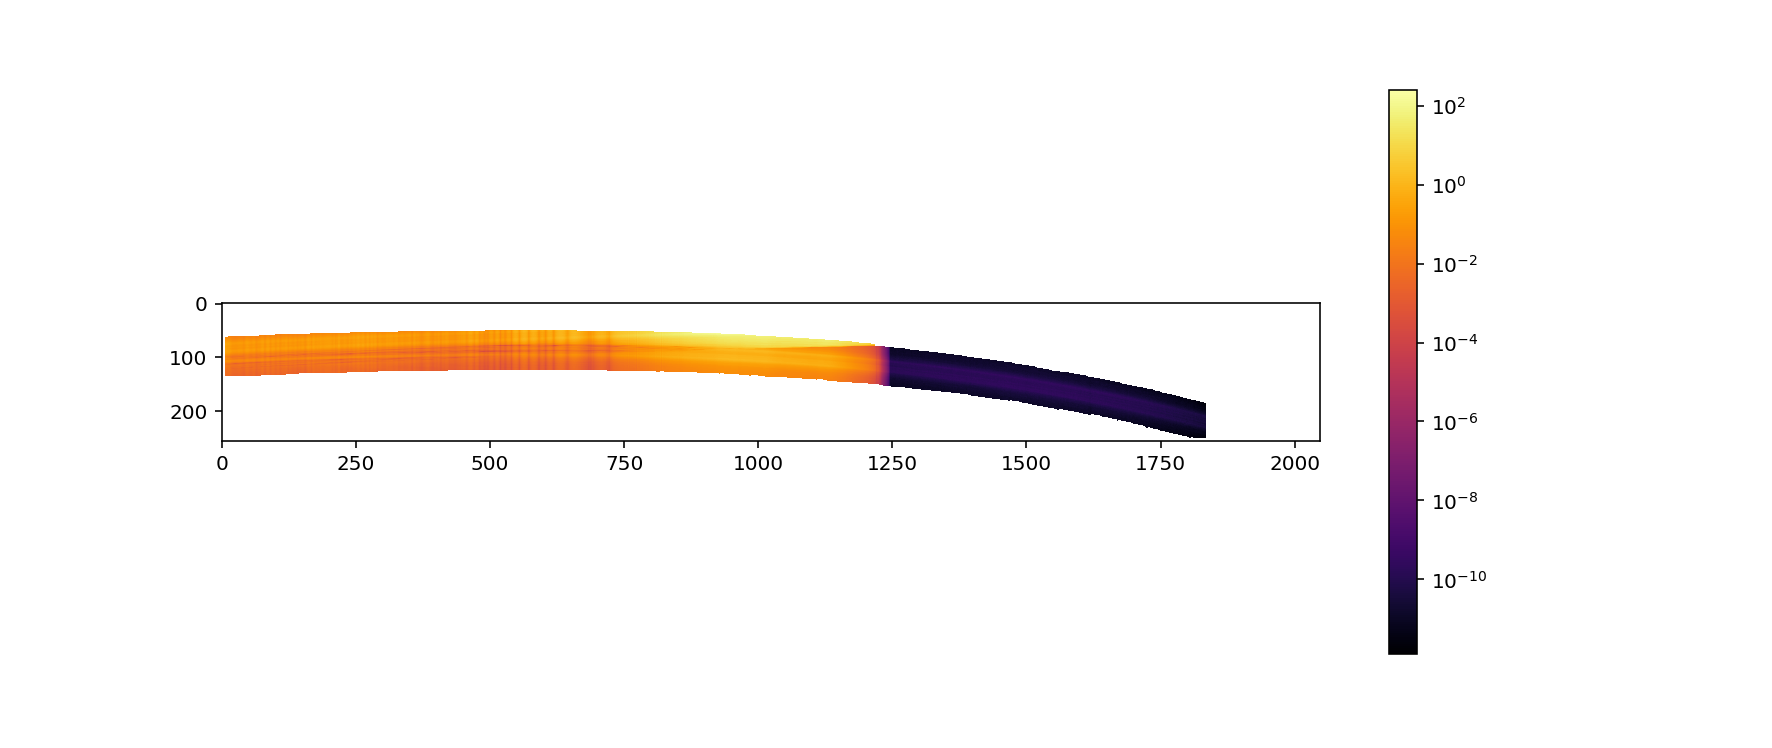

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [40]:
plt.figure()
plt.imshow((np.nanstd(spat_pros_estimates, axis=0)[1]/np.nanmean(spat_pros_estimates, axis=0)[1]/sig*data), norm=LogNorm())
plt.colorbar()

In [41]:
spat_pro_mean = np.nanmean(spat_pros_estimates, axis=0)
# spat_pro_mean[~np.isfinite(spat_pro_mean)] = 0

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


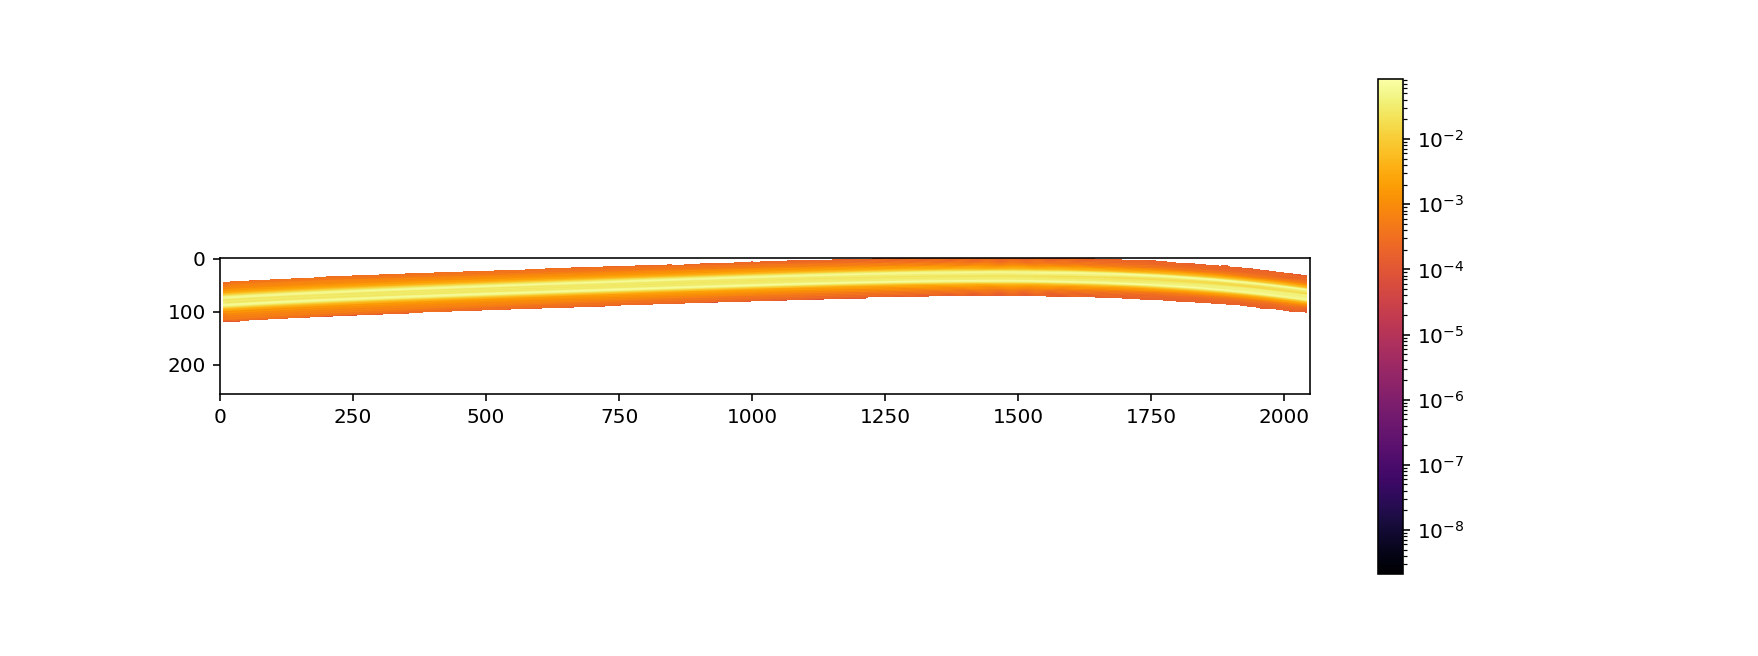

In [42]:
# plt.imshow(((spat_pro_mean-np.array(spat_pros))/spat_pro_mean)[0])
plt.imshow(spat_pro_mean[0], norm=LogNorm())
plt.colorbar()

In [43]:
f_k = extract(data=data, sig=sig, tikhonov=True, factor=best_fac, p_list=spat_pro_mean)
# f_k = extract(data=data, sig=sig)

In [44]:
rebuilt = extract.rebuild(f_k)
rel_err = (extract.data - rebuilt) / rebuilt

<IPython.core.display.Javascript object>


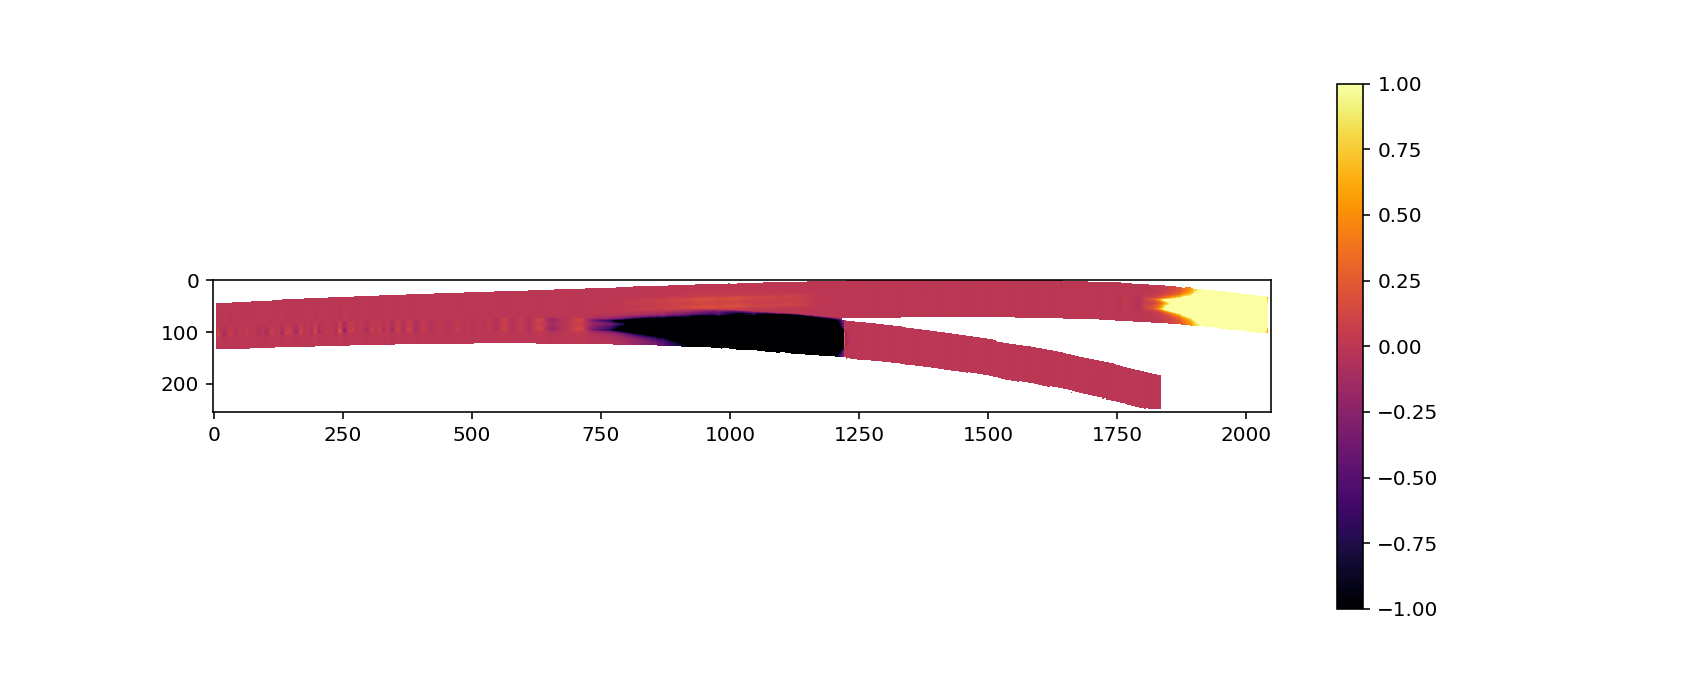

In [45]:
plt.figure()
plt.imshow((rebuilt-data)/sig, vmin=-1, vmax=1, interpolation=None)
plt.colorbar()

<IPython.core.display.Javascript object>


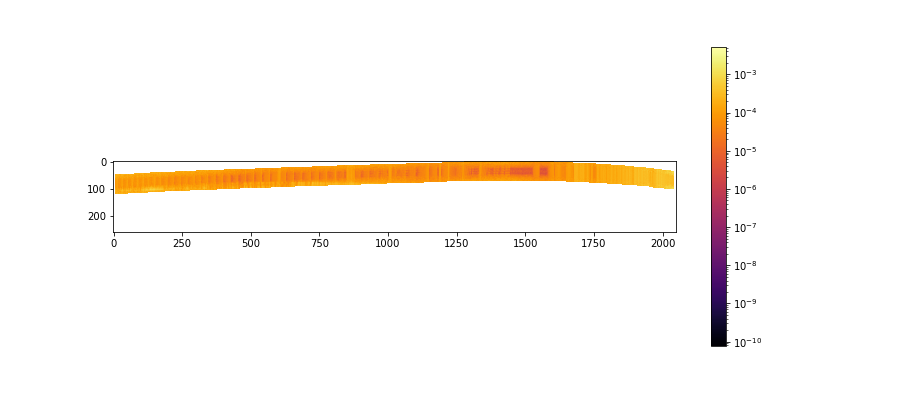

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [133]:
plt.figure()
plt.imshow(np.abs(spat_pros[0]-extract.p_list[0])/spat_pros[0], norm=LogNorm())
plt.colorbar()

<IPython.core.display.Javascript object>


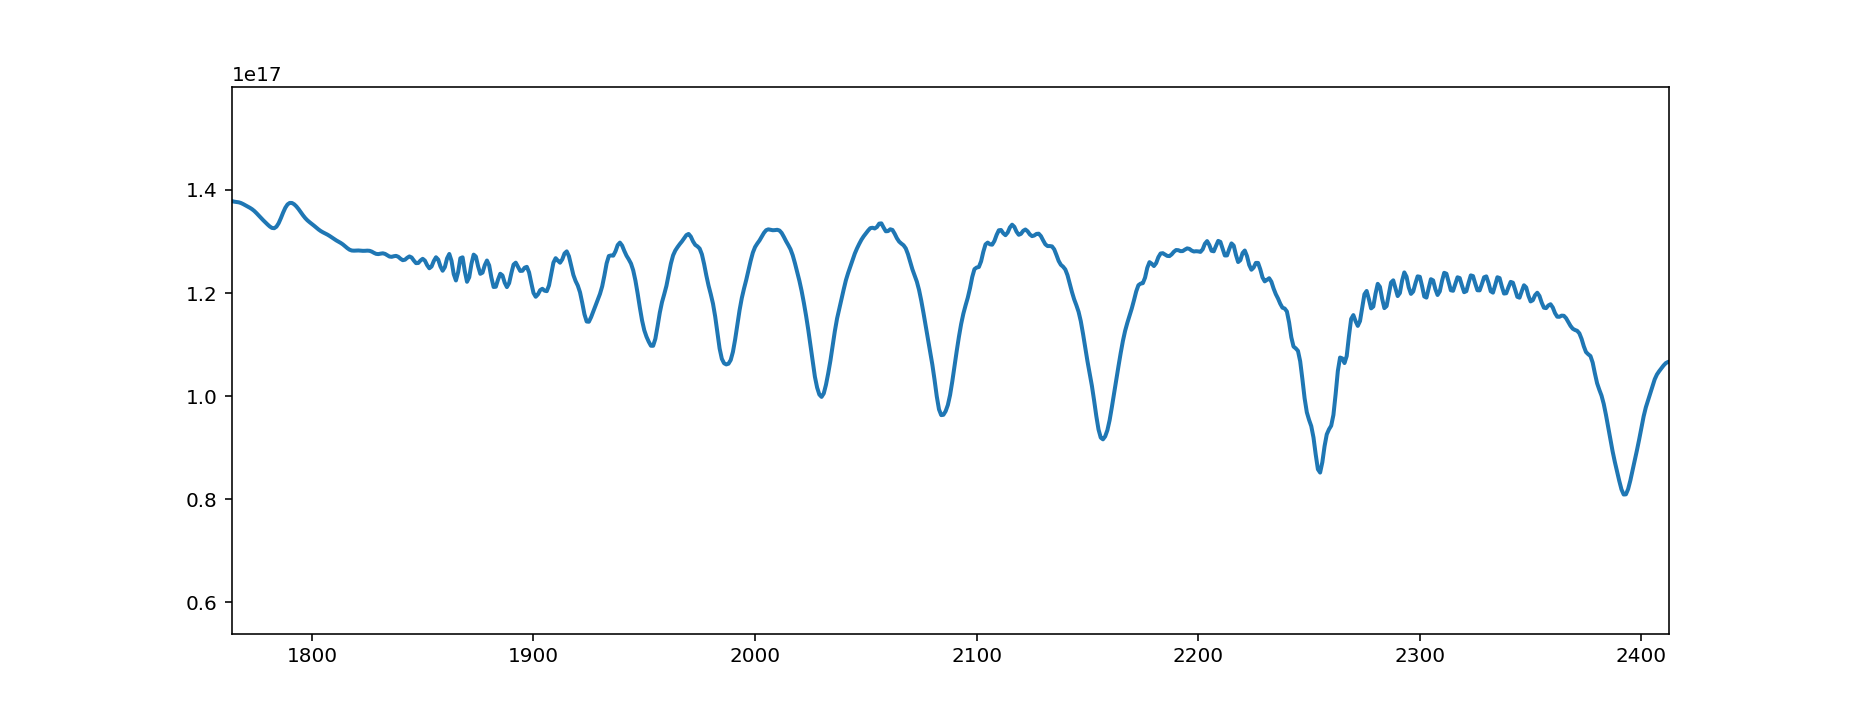

In [46]:
plt.plot(f_k)

<IPython.core.display.Javascript object>


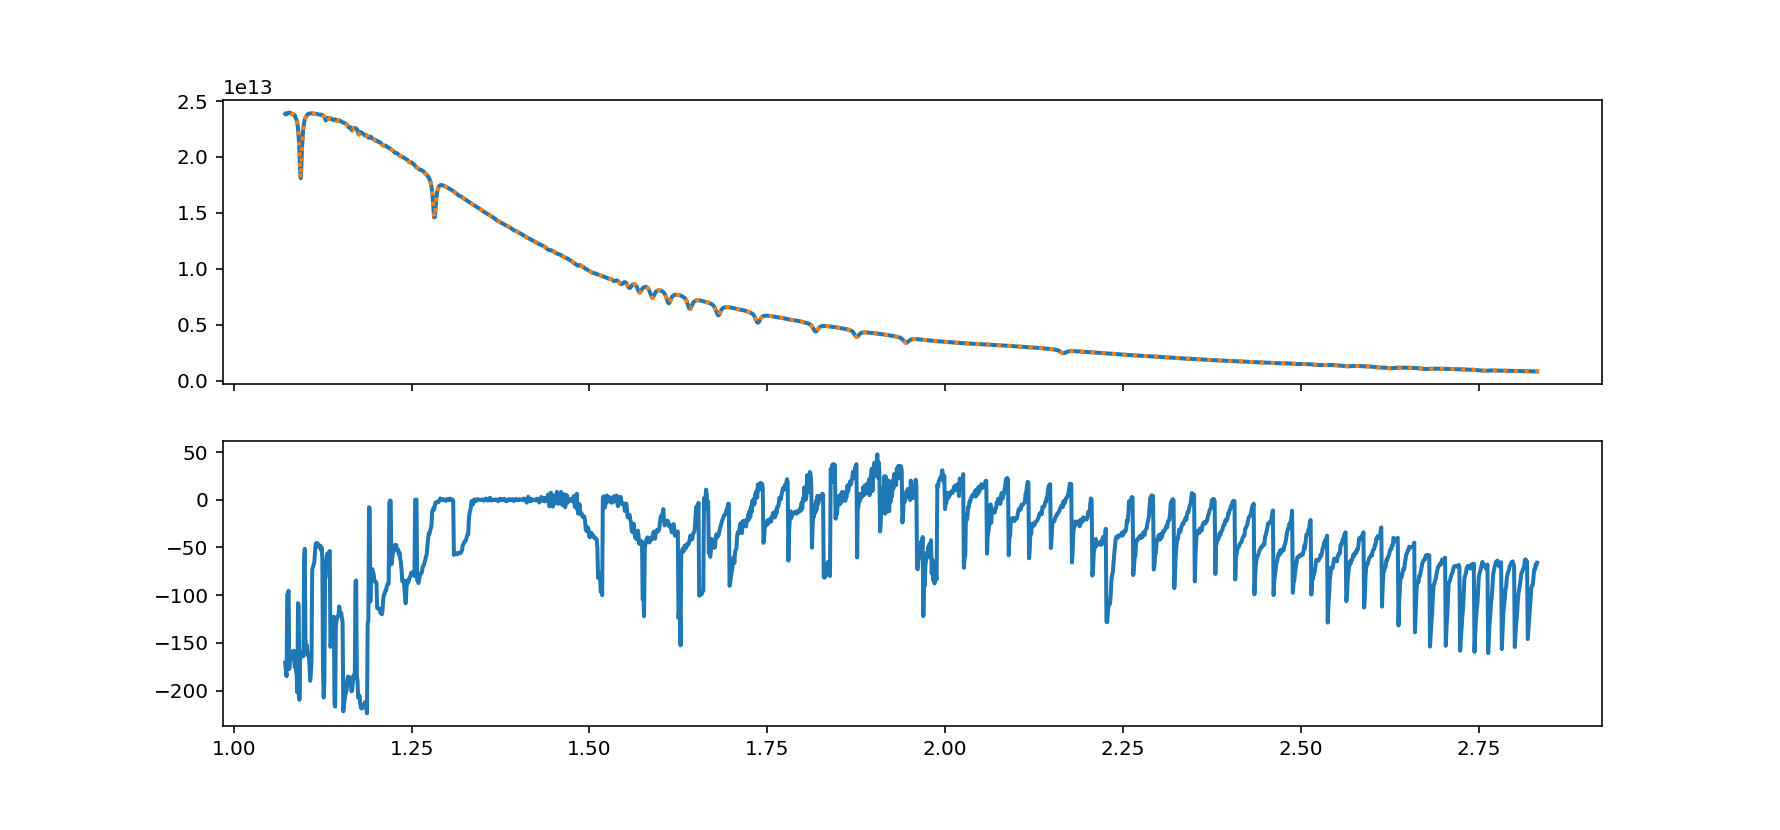

In [47]:
fig, ax = plt.subplots(2, 1, sharex=True)
i_ord = 0

grid_bin, f_bin = extract.bin_to_pixel(f_k_c=extract.c_list[i_ord].dot(f_k),
                                       grid_pix=wave_maps[i_ord][100,:1800],
                                       grid_f_k=extract.lam_grid_c(i_ord), i_ord=i_ord)
_, f_bin_th = extract.bin_to_pixel(f_k_c=simu[f'f_c{i_ord+1}'], 
                                   grid_pix=grid_bin, grid_f_k=simu[f'grid_c{i_ord+1}'], i_ord=i_ord)

ax[0].plot(grid_bin, f_bin)
ax[0].plot(grid_bin, f_bin_th, ":")

# f_th_interp = interp1d(simu['grid_c2'], simu['f_c2'], kind='cubic', bounds_error=False, fill_value=np.nan)
ax[1].plot(grid_bin, (f_bin-f_bin_th)/f_bin_th*1e6)

# im = ax[-1].pcolormesh(wave_maps[1][100,:1800], np.arange(256), ((rebuilt-data)/sig)[:, :1800], vmin=-5, vmax=5)
# # plt.imshow((rebuilt-data)/sig, vmin=-5, vmax=5., interpolation=None)
# plt.colorbar(im, ax=ax[-1], orientation="horizontal")

In [53]:
plt.close()